# Session 1: homework

For the homework, we found a great dataset to practice your linear regression skills on. This dataset has been used in the following publication:

> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 'Modeling wine preferences by data mining from physicochemical properties.' *Decision Support Systems* 47(4):547-553.

Don't copypaste the code for utils.py, but call a fucntion that you need (e.g. utils.train())


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/ML2022/session-1
%cd gdrive/MyDrive/my_ml_2023/session-6

Mounted at /content/gdrive
/content/gdrive/MyDrive/my_ml_2023/session-6


In [ ]:
import utils
import numpy as np
import torch
from torch import nn


# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)



## Preprocessing

Load the dataset (it's also included in the session's folder):

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

You can find the dataset (encoded as csv-files) and load it using `pandas`:

In [ ]:
import pandas as pd
white = pd.read_csv('winequality-white.csv', sep=';')

Let us inspect 10 random instances from the dataset:

In [ ]:
white.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1431,6.1,0.22,0.49,1.5,0.051,18.0,87.0,0.99280,3.30,0.46,9.6,5
445,7.1,0.32,0.32,11.0,0.038,16.0,66.0,0.99370,3.24,0.40,11.5,3
2816,7.2,0.17,0.41,1.6,0.052,24.0,126.0,0.99228,3.19,0.49,10.8,5
4049,6.8,0.16,0.36,1.3,0.034,32.0,98.0,0.99058,3.02,0.58,11.3,6
4779,6.0,0.59,0.00,0.8,0.037,30.0,95.0,0.99032,3.10,0.40,10.9,4
142,7.9,0.21,0.40,1.2,0.039,38.0,107.0,0.99200,3.21,0.54,10.8,6
2703,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5
3252,7.1,0.26,0.37,5.5,0.025,31.0,105.0,0.99082,3.06,0.33,12.6,8
4282,5.7,0.26,0.24,17.8,0.059,23.0,124.0,0.99773,3.30,0.50,10.1,5
46,6.2,0.45,0.26,4.4,0.063,63.0,206.0,0.99400,3.27,0.52,9.8,4


This dataset records, for a large number of (Portugese) wines, a number of objective "physiochemical" properties, such as various kinds of acidity or the level of chlorides. In the very last column ("quality"), it contains a subjective rating for that wine, as an integer  score, ranging from 1 ("very bad") to 10 ("excellent"). This score is a median rating given by at least 3 evaluations made by wine experts.

We'll extract the "quality" column as our $y$ (target value):

In [ ]:
y_label = white['quality'].values
type(y_label)
y_label[:30]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 7, 5, 7, 6, 8, 6, 5, 8, 7,
       8, 5, 6, 6, 6, 6, 6, 7])

We can then drop that column from the dataframe (so that all that remains are input features)

In [ ]:
white = white.drop(['quality'], axis=1)
white.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
3474,6.5,0.22,0.19,1.10,0.064,36.0,191.0,0.99297,3.05,0.50,9.5
3337,6.9,0.38,0.29,13.65,0.048,52.0,189.0,0.99784,3.00,0.60,9.5
1165,6.0,0.24,0.32,6.30,0.030,34.0,129.0,0.99460,3.52,0.41,10.4
1281,7.7,0.27,0.34,1.80,0.028,26.0,168.0,0.99110,2.99,0.48,12.1
2377,7.0,0.22,0.29,8.90,0.050,24.0,90.0,0.99556,3.29,0.46,9.8
4392,6.2,0.25,0.44,15.80,0.057,39.0,167.0,0.99804,3.14,0.51,9.2
840,7.6,0.33,0.35,6.30,0.036,12.0,126.0,0.99240,3.16,0.39,12.0
1755,6.3,0.25,0.23,14.90,0.039,47.0,142.0,0.99705,3.14,0.35,9.7
3483,6.1,0.36,0.26,8.15,0.035,14.0,88.0,0.99031,3.06,0.27,13.0
2714,6.8,0.24,0.37,7.45,0.043,59.0,188.0,0.99579,3.20,0.50,9.4


To extract these features as a purely numeric numpy array, we can do:

In [ ]:
X = white.values

Print the type and shape of X:

In [ ]:
X.shape
type(X)

numpy.ndarray

Let us divide the available data into a train set and test set. It's important to **stratify** these splits in terms of ratings, in order to make sure that we have a similar distribution of ratings in train and test. Scikit-learn has a very convenient function for that:

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_dev_test, y_train, y_dev_test = train_test_split(X, y_label, test_size=0.4,
                                                    random_state=1234, stratify=y_label)

x_dev, x_test, y_dev, y_test = train_test_split(x_dev_test, y_dev_test, test_size=0.5,
                                                    random_state=1234, stratify=y_dev_test)

Note that the stratify argument is crucial. Verify the shapes:

In [ ]:
print(x_train.shape)
print(x_dev.shape)
print(x_test.shape)
print(y_train.shape)
print(y_dev.shape)
print(y_test.shape)

(2938, 11)
(980, 11)
(980, 11)
(2938,)
(980,)
(980,)


0. There's one final bit we need to take care of and that is the normalization of our data. Inspect the feature values in the dataframe above usinf `describe()`, you'll notice that the features cover very different ranges. To account for that it's best to normalize our data. Again: `sklearn` to the rescue! Use `StandardScaler` to normalize the data.

In [ ]:
white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


In [ ]:
from sklearn.preprocessing import StandardScaler

# conventional standardization: remove mean and divide by std
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_dev = scaler.transform(x_dev)
x_test = scaler.transform(x_test)
print(x_train.shape)
print(x_test.shape)

y_scaler = StandardScaler()

# we add a new dimension to y's (it had just one) to fulfil requirements of StandardScaler (2 dimensions)

y_train = np.expand_dims(y_train, axis=1)
y_dev = np.expand_dims(y_dev, axis=1)

y_train = y_scaler.fit_transform(y_train)
y_dev = y_scaler.transform(y_dev)

(2938, 11)
(980, 11)


Two things to note here :
- We only use `x_train` to determine the parameters of our scalar (i.e. the mean and std): cf. `.fit_transform()`
- We apply the fitted scaler to `x_test`, so that we really pretend that we haven't seen the test data yet

Obviously, the shape of our matrices isn't affected.

The following fucntion will map our arrays into data loaders:

In [ ]:
def np2set(x, y, shuffle):
  x = torch.tensor(x, dtype=torch.float)
  y =  torch.tensor(y, dtype=torch.float)

  dataset = torch.utils.data.TensorDataset(x, y)
  iterator = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=shuffle)
  return iterator


## Linear regression

1. Produce an exploratory scatterplot for the training data with `regplot()`. Explore whether you could potentially predict a wine's appreciation level (y_train) by the percentage of alcohol in it (the last feature column in `x_train`). Add proper labels to your x- and y-axes. Describe what you see.

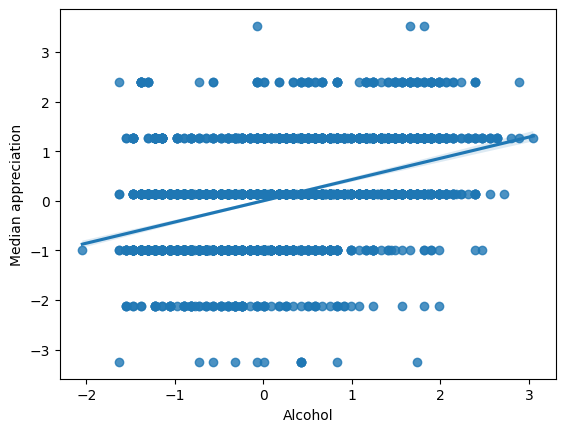

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# code here
sns.regplot(x=x_train[:, 10], y=y_train)
plt.xlabel('Alcohol')
plt.ylabel('Median appreciation');
# there seems to be a positive correlation:
# the "higher" a wine is in alcohol, the "higher" it is rated

2. Base yourself on the code from the notebook in class (call functions from utils.py, but do not copypaste them) and implement a **univariate linear regression** that aims to predict a wine appreciation from the "alcohol" column. Train this model. Use the SGD-optimizer with a learning rate of "0.1" and train for 10 epochs.

In [ ]:
u_train_iter =  np2set(x_train[:, [10]], y_train, shuffle=True)
u_dev_iter =  np2set(x_dev[:, [10]], y_dev, shuffle=False)
u_test_iter = np2set(x_test[:, [10]], y_test, shuffle=False)

In [ ]:
class LinearModel(nn.Module):
  def __init__(self, in_features=1, out_features=1):
    super(LinearModel, self).__init__()
    self.layer = nn.Linear(in_features=in_features, out_features=out_features)

  def forward(self, x):
    return self.layer(x)


uni_model = LinearModel(in_features=1, out_features=1)
uni_model = uni_model.cuda()

history = utils.train(model=uni_model,
                loss=nn.MSELoss(),
                optimizer=torch.optim.SGD(uni_model.parameters(), lr=0.1),
                train_ds=u_train_iter,
                dev_ds=u_dev_iter,
                val_metrics = {"mse": nn.MSELoss()},
                num_epochs=10)

epoch 1 train loss: 0.9388 val_mse: 0.7757
epoch 2 train loss: 0.8200 val_mse: 0.7743
epoch 3 train loss: 0.8198 val_mse: 0.7751
epoch 4 train loss: 0.8192 val_mse: 0.7878
epoch 5 train loss: 0.8198 val_mse: 0.7797
epoch 6 train loss: 0.8200 val_mse: 0.7766
epoch 7 train loss: 0.8208 val_mse: 0.7833
epoch 8 train loss: 0.8195 val_mse: 0.7803
epoch 9 train loss: 0.8203 val_mse: 0.7788
epoch 10 train loss: 0.8199 val_mse: 0.7744


3. Re-run the cell above, but this time, use a learning rate of "0.0001". What changes in the output? Is that good or bad?

In [ ]:
uni_model = LinearModel(in_features=1, out_features=1)
uni_model = uni_model.cuda()

history = utils.train(model=uni_model,
                loss=nn.MSELoss(),
                optimizer=torch.optim.SGD(uni_model.parameters(), lr=0.0001),
                train_ds=u_train_iter,
                dev_ds=u_dev_iter,
                val_metrics = {"mse": nn.MSELoss()},
                num_epochs=10)


# With a smaller learning rate, the loss is much slower to go down, because smaller
# steps are taken towards the minimum of our objective function. This is not necessarily
# a bad thing, but we'll have to train for much longer to get the same result.

epoch 1 train loss: 1.9704 val_mse: 2.0882
epoch 2 train loss: 1.9494 val_mse: 2.0648
epoch 3 train loss: 1.9287 val_mse: 2.0418
epoch 4 train loss: 1.9084 val_mse: 2.0192
epoch 5 train loss: 1.8885 val_mse: 1.9971
epoch 6 train loss: 1.8690 val_mse: 1.9753
epoch 7 train loss: 1.8498 val_mse: 1.9540
epoch 8 train loss: 1.8309 val_mse: 1.9330
epoch 9 train loss: 1.8125 val_mse: 1.9124
epoch 10 train loss: 1.7943 val_mse: 1.8922


4. Retrain the network with a learning rate of 0.001, but this time train for 40 epochs. At which epoch does the loss become stable? Describe in your own words what that means. Plot the loss.

In [ ]:
uni_model = LinearModel(in_features=1, out_features=1)
uni_model = uni_model.cuda()

history = utils.train(model=uni_model,
                loss=nn.MSELoss(),
                optimizer=torch.optim.SGD(uni_model.parameters(), lr=0.001),
                train_ds=u_train_iter,
                dev_ds=u_dev_iter,
                val_metrics = {"mse": nn.MSELoss()},
                num_epochs=40)

# We had no more improvement in the loss after epoch 30-32, i.e. the loss stabilized.
# This means that our network has found the "optimal" line that cuts our samples
# in the scatterplot, minimizing the vertical error bars associated with the MSE.

epoch 1 train loss: 3.0425 val_mse: 3.0489
epoch 2 train loss: 2.6680 val_mse: 2.6696
epoch 3 train loss: 2.3565 val_mse: 2.3538
epoch 4 train loss: 2.0973 val_mse: 2.0910
epoch 5 train loss: 1.8819 val_mse: 1.8725
epoch 6 train loss: 1.7029 val_mse: 1.6901
epoch 7 train loss: 1.5537 val_mse: 1.5384
epoch 8 train loss: 1.4299 val_mse: 1.4121
epoch 9 train loss: 1.3268 val_mse: 1.3066
epoch 10 train loss: 1.2409 val_mse: 1.2189
epoch 11 train loss: 1.1697 val_mse: 1.1457
epoch 12 train loss: 1.1102 val_mse: 1.0846
epoch 13 train loss: 1.0607 val_mse: 1.0338
epoch 14 train loss: 1.0197 val_mse: 0.9913
epoch 15 train loss: 0.9855 val_mse: 0.9559
epoch 16 train loss: 0.9570 val_mse: 0.9263
epoch 17 train loss: 0.9334 val_mse: 0.9017
epoch 18 train loss: 0.9137 val_mse: 0.8812
epoch 19 train loss: 0.8974 val_mse: 0.8640
epoch 20 train loss: 0.8838 val_mse: 0.8497
epoch 21 train loss: 0.8725 val_mse: 0.8377
epoch 22 train loss: 0.8631 val_mse: 0.8277
epoch 23 train loss: 0.8553 val_mse: 0.81

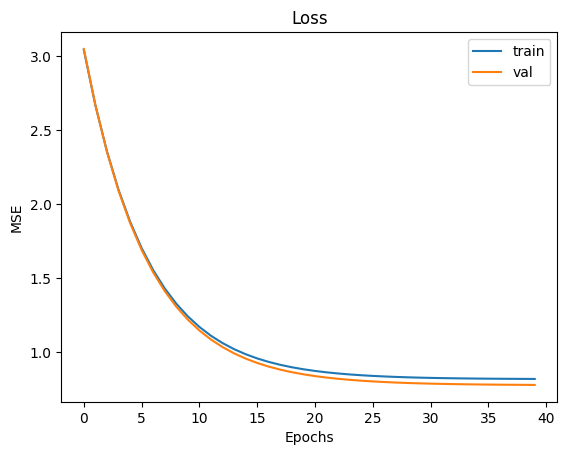

In [ ]:
plt.plot(history["train_loss"], label='train')
plt.plot(history["val_mse"], label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE');
plt.legend()

5. Retrain the network with a learning rate of 0.001, but this time train for 35 epochs.

In [ ]:
uni_model = LinearModel(in_features=1, out_features=1)
uni_model = uni_model.cuda()

history = utils.train(model=uni_model,
                loss=nn.MSELoss(),
                optimizer=torch.optim.SGD(uni_model.parameters(), lr=0.001),
                train_ds=u_train_iter,
                dev_ds=u_dev_iter,
                val_metrics = {"mse": nn.MSELoss()},
                num_epochs=35)

epoch 1 train loss: 2.2693 val_mse: 2.2785
epoch 2 train loss: 2.0250 val_mse: 2.0290
epoch 3 train loss: 1.8217 val_mse: 1.8210
epoch 4 train loss: 1.6526 val_mse: 1.6480
epoch 5 train loss: 1.5120 val_mse: 1.5038
epoch 6 train loss: 1.3950 val_mse: 1.3835
epoch 7 train loss: 1.2977 val_mse: 1.2833
epoch 8 train loss: 1.2168 val_mse: 1.1998
epoch 9 train loss: 1.1495 val_mse: 1.1302
epoch 10 train loss: 1.0935 val_mse: 1.0719
epoch 11 train loss: 1.0469 val_mse: 1.0236
epoch 12 train loss: 1.0082 val_mse: 0.9833
epoch 13 train loss: 0.9761 val_mse: 0.9495
epoch 14 train loss: 0.9492 val_mse: 0.9212
epoch 15 train loss: 0.9269 val_mse: 0.8977
epoch 16 train loss: 0.9084 val_mse: 0.8780
epoch 17 train loss: 0.8930 val_mse: 0.8616
epoch 18 train loss: 0.8802 val_mse: 0.8479
epoch 19 train loss: 0.8695 val_mse: 0.8363
epoch 20 train loss: 0.8606 val_mse: 0.8266
epoch 21 train loss: 0.8532 val_mse: 0.8186
epoch 22 train loss: 0.8471 val_mse: 0.8119
epoch 23 train loss: 0.8420 val_mse: 0.80

6. Predict the appreciations for the wines in the test data. Note that we consider the last column of `x_test`. Calculate the **mean squared error** and **mean absolute error**  between the predictions and the ground truth (in `y_test`). Also: assess this result in your own words: what does this MSE imply in interpretive terms? Plot the training data samples in a scatterplot and add the regression line which the network learned.

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

uni_predictions = utils.test(uni_model, u_test_iter)
uni_predictions = y_scaler.inverse_transform(uni_predictions)


print(f"Univariate MAE: {mae(y_pred=uni_predictions, y_true=y_test)}")
print(f"Univariate MSE: {mse(y_pred=uni_predictions, y_true=y_test)}")

# We're not doing to bad, in the sense that when we predict predict the rating for a wine
# we are only off by ~.65 points (on average we are never more that one appreciation unit
# away from the human judges). From another perspective, this result isn't great because
# we know that most wines in this dataset got a very average rating (but you couldn't know
# that).


Univariate MAE: 0.6309207075952488
Univariate MSE: 0.6469975116858137


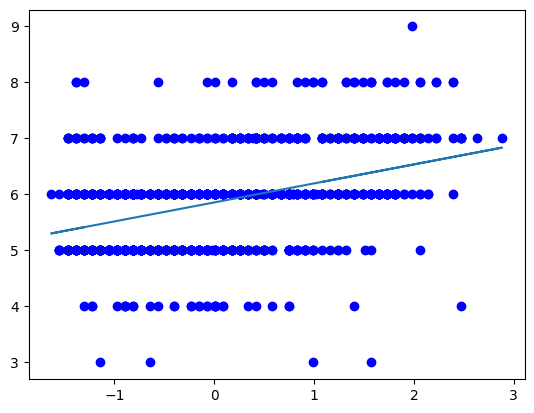

In [ ]:
plt.plot(x_test[:, 10], y_test, 'bo')
plt.plot(x_test[:, 10], uni_predictions)

7. Print correlations draw pair plots (`pairplot`) between the target variables and features. What do you observe? Next on, fit a multivariate network to use all of the feature columns in `x_train`. Adapt the network architecture as necessary (in particular, you'll want to change the number of input features). Use a learning rate of "0.001" and train for 35 epochs. Compare the losses being printed to the univariate model that we ran above and describe what you see.

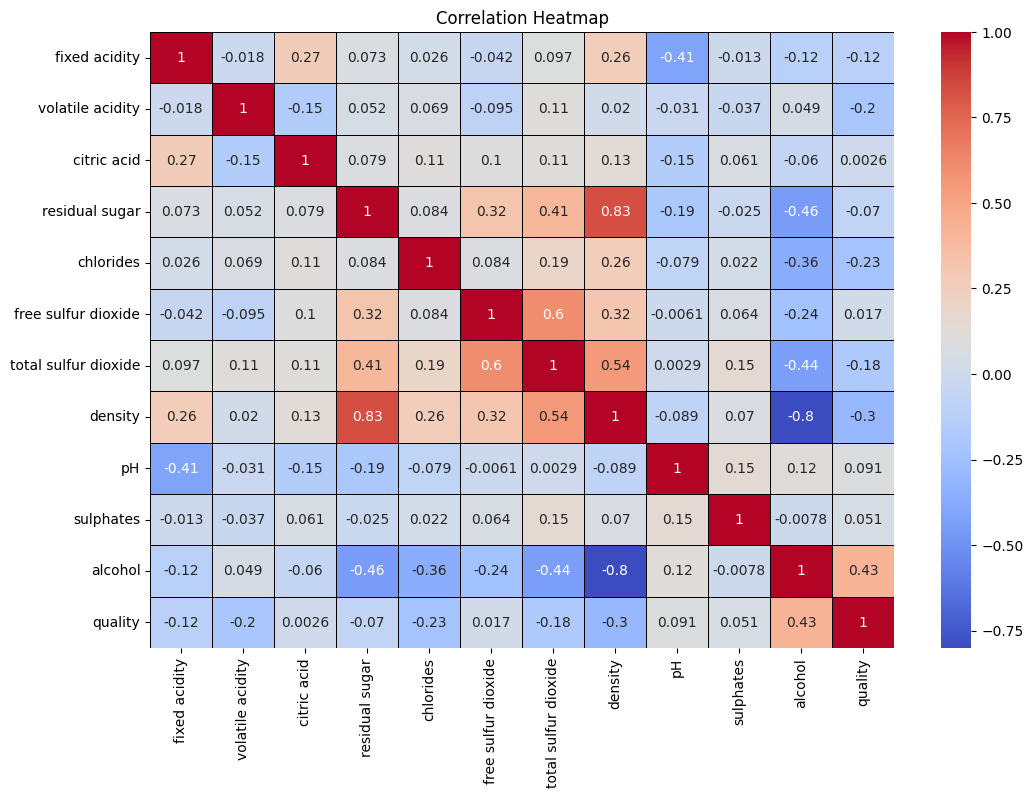

In [ ]:
train_df = pd.DataFrame(np.concatenate([x_train, y_train], axis=1),
                        columns=list(white.columns) + ['quality'])
corr_matrix = train_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Heatmap')
plt.show()

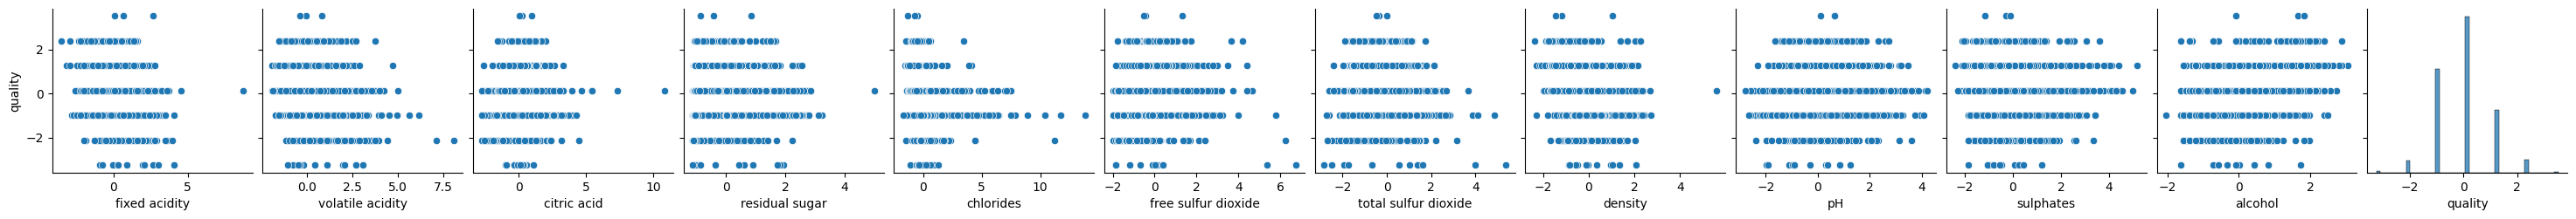

In [ ]:
sns.pairplot(train_df,  y_vars=['quality'])

In [ ]:
train_iter = np2set(x_train, y_train, shuffle=True)
dev_iter  = np2set(x_dev, y_dev, shuffle=False)
test_iter  = np2set(x_test, y_test, shuffle=False)

In [ ]:
multi_model = LinearModel(in_features=11, out_features=1)

multi_model = multi_model.cuda()

history = utils.train(model=multi_model,
                loss=nn.MSELoss(),
                optimizer=torch.optim.SGD(multi_model.parameters(), lr=0.001),
                train_ds=train_iter,
                dev_ds=dev_iter,
                val_metrics = {"mse": nn.MSELoss()},
                num_epochs=35)

epoch 1 train loss: 1.0521 val_mse: 1.0400
epoch 2 train loss: 1.0062 val_mse: 0.9979
epoch 3 train loss: 0.9674 val_mse: 0.9621
epoch 4 train loss: 0.9344 val_mse: 0.9318
epoch 5 train loss: 0.9064 val_mse: 0.9060
epoch 6 train loss: 0.8824 val_mse: 0.8838
epoch 7 train loss: 0.8619 val_mse: 0.8648
epoch 8 train loss: 0.8441 val_mse: 0.8483
epoch 9 train loss: 0.8290 val_mse: 0.8341
epoch 10 train loss: 0.8158 val_mse: 0.8218
epoch 11 train loss: 0.8044 val_mse: 0.8111
epoch 12 train loss: 0.7945 val_mse: 0.8017
epoch 13 train loss: 0.7860 val_mse: 0.7936
epoch 14 train loss: 0.7784 val_mse: 0.7865
epoch 15 train loss: 0.7719 val_mse: 0.7802
epoch 16 train loss: 0.7662 val_mse: 0.7748
epoch 17 train loss: 0.7611 val_mse: 0.7699
epoch 18 train loss: 0.7567 val_mse: 0.7656
epoch 19 train loss: 0.7528 val_mse: 0.7618
epoch 20 train loss: 0.7494 val_mse: 0.7584
epoch 21 train loss: 0.7463 val_mse: 0.7555
epoch 22 train loss: 0.7437 val_mse: 0.7528
epoch 23 train loss: 0.7413 val_mse: 0.75

8. Predict the appreciation ratings for the test data (i.e. the full `x_test` this time) and calculate the MSE and MAE. Did the test results improve? Why (not), you think?

In [ ]:
multi_predictions = utils.test(multi_model, test_iter)
multi_predictions = y_scaler.inverse_transform(multi_predictions)

In [ ]:
print(f"Univariate MAE: {mae(y_pred=uni_predictions, y_true=y_test)}")
print(f"Multivariate MAE: {mae(y_pred=multi_predictions, y_true=y_test)}")


print(f"Univariate MSE: {mse(y_pred=uni_predictions, y_true=y_test)}")
print(f"Multivariate MSE: {mse(y_pred=multi_predictions, y_true=y_test)}")


Univariate MAE: 0.6307853085235687
Multivariate MAE: 0.5938040335219762
Univariate MSE: 0.6486448135390608
Multivariate MSE: 0.580396150769679


9. Go through all of the preprocessing steps above again, but this time for the red wine dataset (loading, cleaning, splitting, scaling, etc.). Make sure to copy all the relevant code, so that in the code blocks below, you again obtain a suitable `x_train`, `x_test`, `y_train`, and `y_test` but this time for the *red* wines. You can obtain the relevant red wine dataset as follows:

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

--2023-11-09 16:42:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘winequality-red.csv’

winequality-red.csv     [ <=>                ]  82.23K  --.-KB/s    in 0.03s   

2023-11-09 16:42:14 (3.08 MB/s) - ‘winequality-red.csv’ saved [84199]



In [ ]:
red = pd.read_csv('winequality-red.csv', sep=';')
y = red['quality'].values
red = red.drop(['quality'], axis=1)
X = red.values

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_dev_test, y_train, y_dev_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=1234, stratify=y)

x_dev, x_test, y_dev, y_test = train_test_split(x_dev_test, y_dev_test, test_size=0.5,
                                                    random_state=1234, stratify=y_dev_test)

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_dev = scaler.transform(x_dev)
x_test = scaler.transform(x_test)
print(x_test.shape)

y_scaler = StandardScaler()

# we add a new dimension to y's (it had just one) to fulfil requirements of StandardScaler (2 dimensions)

y_train = np.expand_dims(y_train, axis=1)
y_dev = np.expand_dims(y_dev, axis=1)
y_train = y_scaler.fit_transform(y_train)
y_dev = y_scaler.transform(y_dev)

u_train_iter =  np2set(x_train[:, [10]], y_train, shuffle=True)
u_dev_iter =  np2set(x_dev[:, [10]], y_dev, shuffle=False)
u_test_iter = np2set(x_test[:, [10]], y_test, shuffle=False)

train_iter = np2set(x_train, y_train, shuffle=True)
dev_iter  = np2set(x_dev, y_dev, shuffle=False)
test_iter  = np2set(x_test, y_test, shuffle=False)

(320, 11)


10. Train a univariate network to model the effect of alcoholic percentage on the *red* wines' appreciations. (You can determine a suitable learning rate and number of epochs yourself...) Print the parameters learned by your model: is the effect similar to that for the white wines? Plot the regression line.

In [ ]:
uni_model = LinearModel(in_features=1, out_features=1)
uni_model = uni_model.cuda()

history = utils.train(model=uni_model,
                loss=nn.MSELoss(),
                optimizer=torch.optim.SGD(uni_model.parameters(), lr=0.001),
                train_ds=u_train_iter,
                dev_ds=u_dev_iter,
                val_metrics = {"mse": nn.MSELoss()},
                num_epochs=35)

epoch 1 train loss: 0.8010 val_mse: 0.9127
epoch 2 train loss: 0.7977 val_mse: 0.9090
epoch 3 train loss: 0.7946 val_mse: 0.9055
epoch 4 train loss: 0.7916 val_mse: 0.9022
epoch 5 train loss: 0.7888 val_mse: 0.8990
epoch 6 train loss: 0.7862 val_mse: 0.8961
epoch 7 train loss: 0.7837 val_mse: 0.8932
epoch 8 train loss: 0.7815 val_mse: 0.8905
epoch 9 train loss: 0.7792 val_mse: 0.8880
epoch 10 train loss: 0.7772 val_mse: 0.8856
epoch 11 train loss: 0.7753 val_mse: 0.8833
epoch 12 train loss: 0.7734 val_mse: 0.8811
epoch 13 train loss: 0.7717 val_mse: 0.8791
epoch 14 train loss: 0.7701 val_mse: 0.8771
epoch 15 train loss: 0.7686 val_mse: 0.8753
epoch 16 train loss: 0.7672 val_mse: 0.8735
epoch 17 train loss: 0.7658 val_mse: 0.8718
epoch 18 train loss: 0.7645 val_mse: 0.8702
epoch 19 train loss: 0.7633 val_mse: 0.8687
epoch 20 train loss: 0.7622 val_mse: 0.8673
epoch 21 train loss: 0.7611 val_mse: 0.8659
epoch 22 train loss: 0.7602 val_mse: 0.8647
epoch 23 train loss: 0.7592 val_mse: 0.86

12. Fit a multivariate network to the red wines dataset, this time using *all* of the available feature columns in `X_train`. You can play around with the learning rate and the number of epochs to optimize your performance on the training data. Compute the performance of your trained model on the test data, using the mean squared error. Compare the MSE and MAE to the univariate case.

In [ ]:
multi_model = LinearModel(in_features=11, out_features=1)

multi_model = multi_model.cuda()

history = utils.train(model=multi_model,
                loss=nn.MSELoss(),
                optimizer=torch.optim.SGD(multi_model.parameters(), lr=0.001),
                train_ds=train_iter,
                dev_ds=dev_iter,
                val_metrics = {"mse": nn.MSELoss()},
                num_epochs=35)

epoch 1 train loss: 1.5887 val_mse: 1.4578
epoch 2 train loss: 1.4869 val_mse: 1.3742
epoch 3 train loss: 1.3976 val_mse: 1.3007
epoch 4 train loss: 1.3190 val_mse: 1.2361
epoch 5 train loss: 1.2497 val_mse: 1.1790
epoch 6 train loss: 1.1886 val_mse: 1.1289
epoch 7 train loss: 1.1348 val_mse: 1.0844
epoch 8 train loss: 1.0871 val_mse: 1.0450
epoch 9 train loss: 1.0449 val_mse: 1.0102
epoch 10 train loss: 1.0072 val_mse: 0.9791
epoch 11 train loss: 0.9737 val_mse: 0.9513
epoch 12 train loss: 0.9438 val_mse: 0.9265
epoch 13 train loss: 0.9170 val_mse: 0.9043
epoch 14 train loss: 0.8931 val_mse: 0.8844
epoch 15 train loss: 0.8717 val_mse: 0.8665
epoch 16 train loss: 0.8526 val_mse: 0.8506
epoch 17 train loss: 0.8353 val_mse: 0.8362
epoch 18 train loss: 0.8197 val_mse: 0.8231
epoch 19 train loss: 0.8057 val_mse: 0.8114
epoch 20 train loss: 0.7930 val_mse: 0.8008
epoch 21 train loss: 0.7816 val_mse: 0.7912
epoch 22 train loss: 0.7712 val_mse: 0.7824
epoch 23 train loss: 0.7616 val_mse: 0.77

In [ ]:

uni_predictions = utils.test(uni_model, u_test_iter)
uni_predictions = y_scaler.inverse_transform(uni_predictions)

multi_predictions = utils.test(multi_model, test_iter)
multi_predictions = y_scaler.inverse_transform(multi_predictions)


In [ ]:
print(f"Univariate MAE: {mae(y_pred=uni_predictions, y_true=y_test)}")
print(f"Multivariate MAE: {mae(y_pred=multi_predictions, y_true=y_test)}")


print(f"Univariate MSE: {mse(y_pred=uni_predictions, y_true=y_test)}")
print(f"Multivariate MSE: {mse(y_pred=multi_predictions, y_true=y_test)}")


Univariate MAE: 0.5586483188386501
Multivariate MAE: 0.5318449110068363
Univariate MSE: 0.5299445394233826
Multivariate MSE: 0.45886764734210483
